# [Label Propagation digits active learning](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html)

## 載入相關套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix

## 載入資料集

In [2]:
digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

# 取前 330 筆資料
X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

# 參數設定
n_total_samples = len(y)
n_labeled_points = 40    # 初始取40筆標註資料
max_iterations = 5       # 5 個執行週期

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
len(unlabeled_indices)

290

## Label propagation 模型訓練與評估

Iteration 0 ______________________________________________________________________
Label Spreading model: 40 labeled & 290 unlabeled (330 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.78      0.69      0.73        26
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        27
           4       0.92      0.96      0.94        23
           5       0.96      0.70      0.81        33
           6       0.97      0.97      0.97        35
           7       0.94      0.91      0.92        33
           8       0.62      0.89      0.74        28
           9       0.73      0.79      0.76        34

    accuracy                           0.87       290
   macro avg       0.89      0.87      0.87       290
weighted avg       0.88      0.87      0.87       290

Confusion matrix
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 18  2  0  0  0  1  0  5  0]
 [ 0  0 27  0

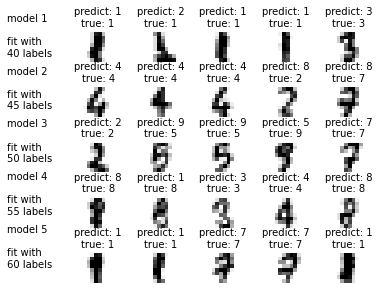

In [3]:
f = plt.figure()
for i in range(max_iterations):
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    # LabelSpreading 模型訓練
    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    # 預測
    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    print(f"Iteration {i} {70 * '_'}")
    print(
        f"Label Spreading model: {n_labeled_points} labeled & " +
        f"{n_total_samples - n_labeled_points} unlabeled ({n_total_samples} total)"
    )
    
    if i==0 or i==max_iterations-1:
        print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)
    print(cm)

    # 計算熵，以找出最不確定的五筆資料
    pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)
    ][:5]

    # 記錄最不確定的五筆資料
    delete_indices = np.array([], dtype=int)
    f.text(
        0.05,
        (1 - (i + 1) * 0.183),
        f"model {i + 1}\n\nfit with\n{n_labeled_points} labels",
        size=10,
    )
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        sub = f.add_subplot(5, 5, index + 1 + (5 * i))
        sub.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
        sub.set_title(
            f"predict: {lp_model.transduction_[image_index]}\ntrue: {y[image_index]}",
            size=10,
        )
        sub.axis("off")

        # 將最不確定的五筆資料加入待刪除的陣列
        (delete_index,) = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    # 將最不確定的五筆資料加入標註資料
    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

print("\n最不確定的五筆資料：")
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2, hspace=0.85)